# Raw Conditioned Backtest

Here is what is known <br>
1. Trading conditioned on Citi Surprise Indices ```IndexBacktest.ipynb``` seems to work
2. Trading conditiond on Citi Surprise Indices ```PCABacktest.ipynb``` seems to work as well

Now in this case compare the results to see if there are recognizable patterns.

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FXCarryCitiSurprise\root\src")
from CitiPCA import PCAModel

In [3]:
def get_citi_backtest() -> pd.DataFrame: 
    
    df_raw = PCAModel().get_citi_suprise()

    securities = (df_raw.drop(
        columns = ["value"]).
        groupby("security").
        agg(["min", "max", "count"])
        ["date"].
        query("count > 500").
        index.
        to_list())

    df_citi = df_raw.query("security == @securities")
    
    keep_cols = ["FXCARRSP"]

    df_carry = (PCAModel().get_misc_indices().query(
        "security == @keep_cols").
        pivot(index = "date", columns = "security", values = "rtn"))
    
    df_signal = (df_citi.pivot(
        index = "date", columns = "security", values = "value").
        shift().
        apply(lambda x: np.sign(x)).
        reset_index().
        melt(id_vars = "date").
        dropna().
        merge(right = df_carry, how = "inner", on = ["date"]).
        assign(signal_rtn = lambda x: np.sign(x.value) * x.FXCARRSP))
    
    return df_signal

In [4]:
def _lag_value(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(lag_value = lambda x: x.value.shift()).
        dropna())
    
    return df_out

def get_pca_backtest() -> pd.DataFrame: 
    
    keep_groups = "FXCARRSP"
    df_signal   = (PCAModel().pca().drop(
        columns = ["explained_variance_ratio"]).
        groupby("pc").
        apply(_lag_value).
        reset_index(drop = True))

    df_pc_signal = pd.DataFrame()

    pcs = df_signal.pc.drop_duplicates().sort_values().to_list()
    for i in range(len(pcs)):

        tmp_pcs = ["PC{}".format(j + 1) for j in range(i + 1)]
        df_tmp  = (df_signal.query(
            "pc == @tmp_pcs").
            pivot(index = "date", columns = "pc", values = "lag_value").
            mean(axis = 1).
            to_frame(name = "signal").
            assign(port = str(i + 1) + "PCs"))

        df_pc_signal = pd.concat([df_pc_signal, df_tmp])

    df_out = (PCAModel().get_misc_indices().query(
        "security == @keep_groups")
        [["date", "security", "rtn"]].
        pivot(index = "date", columns = "security", values = "rtn").
        merge(right = df_pc_signal, how = "inner", on = ["date"]).
        assign(signal_rtn = lambda x: np.sign(x.signal) * x.FXCARRSP))
    
    return df_out

def get_backtest() -> pd.DataFrame: 

    df_citi_backtest = get_citi_backtest()
    df_pca_backtest  = get_pca_backtest()


    df_citi_tmp = (df_citi_backtest.rename(
        columns = {"security": "port"})
        [["date", "port", "signal_rtn"]].
        assign(port_group = "CitiSurprise"))

    df_pca_tmp = (df_pca_backtest.reset_index()[
        ["date", "port", "signal_rtn"]].
        assign(port_group = "PCA"))
    
    keep_cols = ["FXCARRSP"]

    df_carry = (PCAModel().get_misc_indices().query(
        "security == @keep_cols").
        pivot(index = "date", columns = "security", values = "rtn"))

    df_combined = (pd.concat(
        [df_citi_tmp, df_pca_tmp]).
        merge(right = df_carry, how = "inner", on = ["date"]))
    
    return df_combined

df = get_backtest()

## Plot Performance

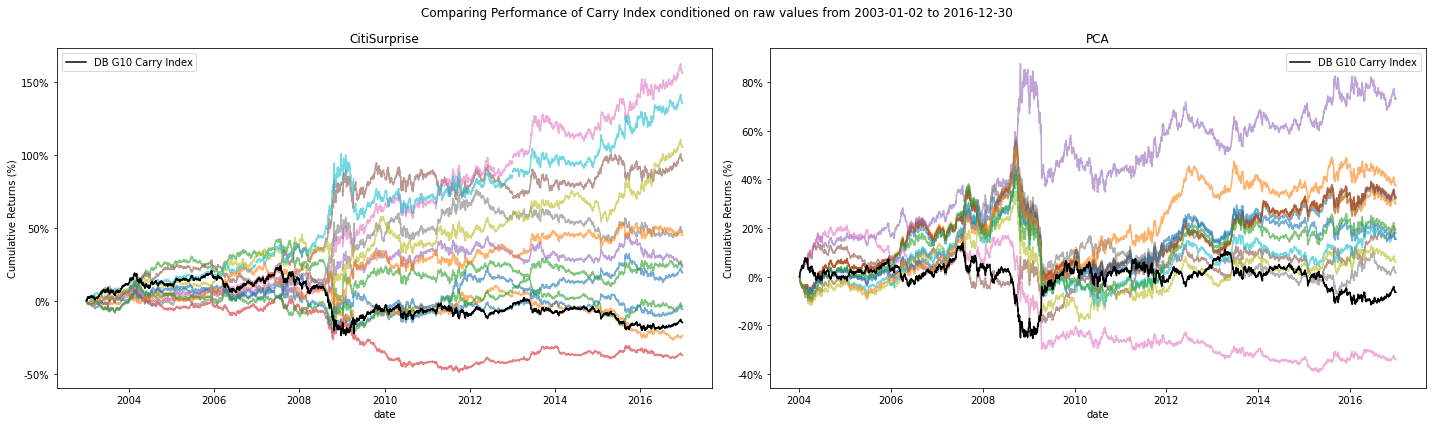

In [10]:
def plot_performance(df: pd.DataFrame) -> plt.Figure: 
    
    port_groups = df.port_group.drop_duplicates().sort_values().to_list()
    fig, axes   = plt.subplots(ncols = len(port_groups), figsize = (20,6))

    for port_group, ax in zip(port_groups, axes.flatten()):

        df_plot = (df.query(
            "port_group == @port_group").
            rename(columns = {"port": ""}).
            pivot(index = ["date", "FXCARRSP"], columns = "", values = "signal_rtn").
            reset_index().
            set_index("date"))

        (df_plot.drop(
            columns = ["FXCARRSP"]).
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                legend = False,
                alpha  = 0.6))

        (df_plot[
            ["FXCARRSP"]].
            drop_duplicates().
            rename(columns = {"FXCARRSP": "DB G10 Carry Index"}).
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                color  = "black",
                ylabel = "Cumulative Returns (%)",
                title  = port_group))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("Comparing Performance of Carry Index conditioned on raw values from {} to {}".format(
        df.date.min(),
        df.date.max()))
    
    plt.tight_layout()
    
plot_performance(df)

## Getting best, worst, and median sharpe strategies

In this case get the sharpes of each portfolio and then get the best, worst, and median sharpes. 

In [6]:
def _get_best_worst_median_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (pd.concat([
        df.query("sharpe == sharpe.min()").assign(sharpe = "min_sharpe"),
        df.query("sharpe == sharpe.max()").assign(sharpe = "max_sharpe"),
        df.query("sharpe == sharpe.median()").assign(sharpe = "median_sharpe")]))
    
    return df_out

def get_best_worst_median_sharpe(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.drop(
        columns = ["FXCARRSP", "date"]).
        groupby(["port", "port_group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn).
        reset_index().
        groupby("port_group").
        apply(_get_best_worst_median_sharpe).
        reset_index(drop = True))
    
    return df_out

df_best_worst_sharpe = get_best_worst_median_sharpe(df)

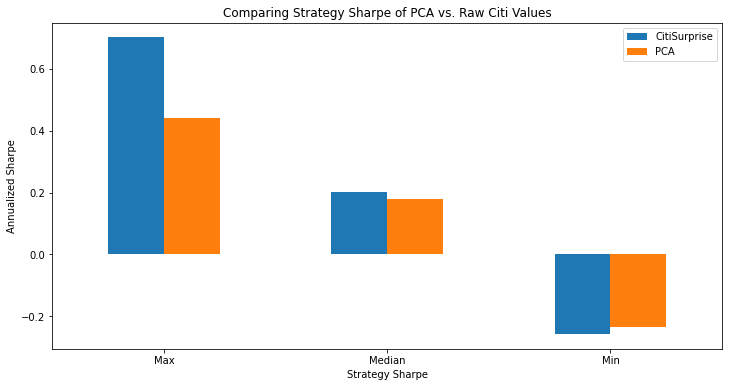

In [7]:
def plot_best_worst_sharpe(df_best_worst_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_best_worst_sharpe.assign(
        sharpe_val = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252),
        sharpe_group = lambda x: x.sharpe.str.split("_").str[0].str.capitalize()).
        rename(columns = {"port_group": ""}).
        pivot(index = "sharpe_group", columns = "", values = "sharpe_val").
        plot(
            kind    = "bar",
            rot     = 0,
            xlabel  = "Strategy Sharpe",
            figsize = (12,6),
            title   = "Comparing Strategy Sharpe of PCA vs. Raw Citi Values",
            ylabel  = "Annualized Sharpe"))
    
plot_best_worst_sharpe(df_best_worst_sharpe)

In [8]:
def get_best_worst_median_perf(df_best_worst_sharpe: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame: 
    
    df_combined = (df_best_worst_sharpe.merge(
        right = df, how = "inner", on = ["port", "port_group"]))
    
    return df_combined

df_best_worst_median = get_best_worst_median_perf(df_best_worst_sharpe, df)

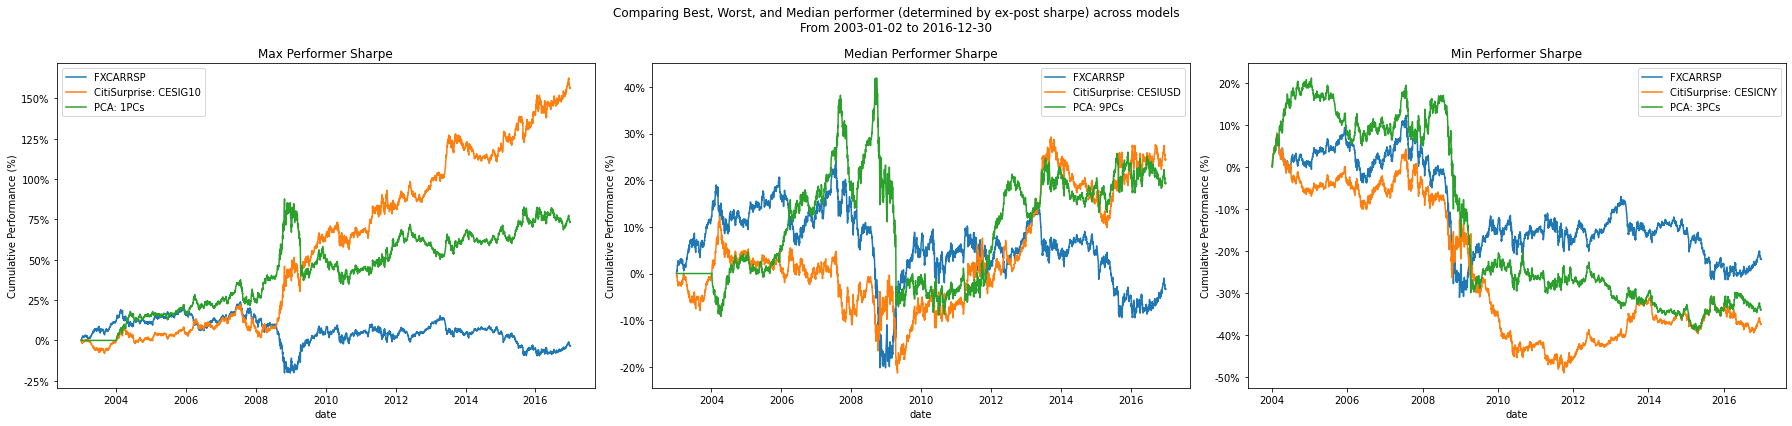

In [9]:
def plot_best_wort_median_perf(df_best_worst_median: pd.DataFrame) -> plt.Figure: 
    
    groups    = df_best_worst_median.sharpe.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(groups), figsize = (25,6))

    for group, ax in zip(groups, axes.flatten()):

        (df_best_worst_median.query(
            "sharpe == @group").
            assign(tmp = lambda x: x.port_group + ": " + x.port).
            rename(columns = {"tmp": ""}).
            pivot(index = ["date", "FXCARRSP"], columns = "", values = "signal_rtn").
            fillna(0).
            reset_index().
            set_index("date").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                ylabel = "Cumulative Performance (%)",
                title  = group.split("_")[0].capitalize() + " Performer Sharpe"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("Comparing Best, Worst, and Median performer (determined by ex-post sharpe) across models\nFrom {} to {}".format(
        df_best_worst_median.date.min(),
        df_best_worst_median.date.max()))
    plt.tight_layout()
    
plot_best_wort_median_perf(df_best_worst_median)